In [33]:
from pathlib import Path
from skimage.transform import resize
import skimage
import re
import h5py
import numpy as np
import matplotlib.pyplot as plt


cube_config = re.compile(r"[rgbwyo]{27}")


def create_dataset(path):
    images = []
    configs = []

    training_set = Path(path)
    for i, file_path in enumerate(training_set.glob("*")):
        bla = cube_config.search(file_path.stem)
        if bla is None:
            continue
        image = skimage.io.imread(file_path)
        image = image[:,:,:3]  # discard alpha
        image = resize(image, (128, 128), anti_aliasing=True)
        config = bla.group(0)
        images.append(image)
        configs.append(config)

    training_set_x = np.array(images)
    training_set_y = np.zeros(shape=(len(configs), 27*6))
    color_indexes = {c:i for i, c in enumerate("rgbwyo")}

    for i, config in enumerate(configs):
        for j, color in enumerate(config):
            c = color_indexes[color]
            training_set_y[i][j*6 + c] = 1
    
    np.random.seed(321)
    reordering = np.random.permutation(len(images))

    return training_set_x[reordering], training_set_y[reordering]

data_x, data_y = create_dataset("training_set")
data_y = data_y.reshape(-1, 27, 6)

n_train = int(data_x.shape[0] * 0.7)
train_x = data_x[:n_train]
train_y = data_y[:n_train]
test_x = data_x[n_train:]
test_y = data_y[n_train:]

In [34]:
import tensorflow as tf


conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(20, (3,3), 
                            input_shape=(128, 128, 3), 
                            kernel_initializer="random_uniform", 
                            kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(10, (3,3), kernel_initializer="random_uniform", kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(500, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(27*6, activation="tanh"),
    tf.keras.layers.Reshape((27, 6)),
    tf.keras.layers.Activation("softmax"),
],
name="Cube"
)

tf.keras.utils.set_random_seed(123)
opt = tf.keras.optimizers.SGD(learning_rate=0.1)

conv_model.compile(
    "adam",
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)
conv_model.build(train_x.shape, )
conv_model.summary()

Model: "Cube"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 20)      560       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 20)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 10)        1810      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 10)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 9000)              0         
                                                                 
 dropout_4 (Dropout)         (None, 9000)              0      

Epoch 1/100
13/13 [==============================] - 1s 39ms/step - loss: 1.7980 - accuracy: 0.2065 - val_loss: 1.7881 - val_accuracy: 0.2545
Epoch 2/100
13/13 [==============================] - 0s 30ms/step - loss: 1.6925 - accuracy: 0.3495 - val_loss: 1.6354 - val_accuracy: 0.3622
Epoch 3/100
13/13 [==============================] - 0s 31ms/step - loss: 1.4219 - accuracy: 0.4962 - val_loss: 1.4226 - val_accuracy: 0.4710
Epoch 4/100
13/13 [==============================] - 0s 31ms/step - loss: 1.1878 - accuracy: 0.6277 - val_loss: 1.3149 - val_accuracy: 0.5391
Epoch 5/100
13/13 [==============================] - 0s 30ms/step - loss: 1.0752 - accuracy: 0.7029 - val_loss: 1.2609 - val_accuracy: 0.5787
Epoch 6/100
13/13 [==============================] - 0s 30ms/step - loss: 0.9991 - accuracy: 0.7592 - val_loss: 1.2277 - val_accuracy: 0.5967
Epoch 7/100
13/13 [==============================] - 0s 30ms/step - loss: 0.9504 - accuracy: 0.7863 - val_loss: 1.1967 - val_accuracy: 0.6277
Epoch 

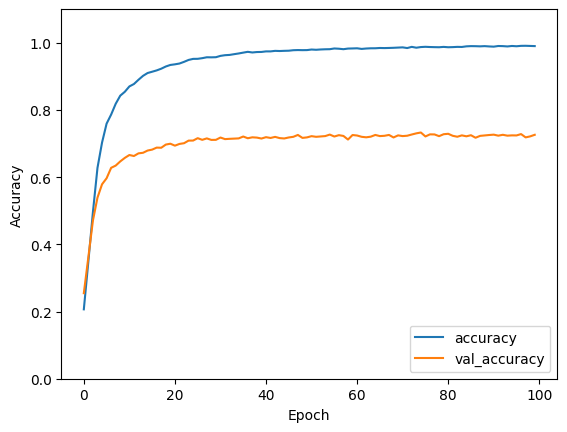

In [35]:
results = conv_model.fit(
    train_x,
    train_y.reshape(-1, 27, 6),
    validation_data=(test_x, test_y),
    epochs=100,
)

plt.plot(results.history['accuracy'], label='accuracy')
plt.plot(results.history['val_accuracy'], label='val_accuracy')

plt.ylim([0, 1.1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

1/1 [==============================] - 0s 12ms/step


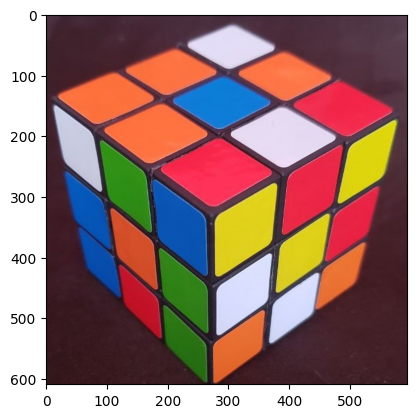

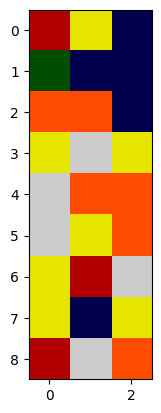

found config:     rwbgbbyybwowoyyowywrowbwroy


In [43]:
import skimage


def extract_config(array):
    colors_char = "rgbowy"
    return "".join([colors_char[i] for i in np.argmax(array, axis=1)])

def extract_colors(image):
    red = (0.7, 0, 0)
    green = (0, 0.3, 0)
    blue = (0, 0, 0.3)
    white = (0.8, 0.8, 0.8)
    yellow = (0.9, 0.9, 0)
    orange = (1, 0.3, 0)
    common_colors = np.array([red, green, blue, white, yellow, orange])
    image = resize(image, (128, 128), anti_aliasing=True)
    result = conv_model.predict(np.array([image]))

    config = extract_config(result[0])
    colors = np.array([common_colors[i] for i in np.argmax(result[0], axis=1)])
    return colors.reshape(3, 9, 3), config


file_path = "test_images/cube_8.jpg"
image = skimage.io.imread(file_path)

found_colors, found_config = extract_colors(image)
plt.imshow(image)
plt.show()
plt.imshow(found_colors.reshape(9, 3, 3))
plt.hlines(-0.5, xmin=-0.5, xmax=2.5, color="black", linewidth=4)
plt.hlines(2.5, xmin=-0.5, xmax=2.5, color="black", linewidth=4)
plt.hlines(5.5, xmin=-0.5, xmax=2.5, color="black", linewidth=4)
plt.hlines(8.5, xmin=-0.5, xmax=2.5, color="black", linewidth=4)
plt.vlines(-0.5, ymin=-0.5, ymax=8.5, color="black", linewidth=4)
plt.vlines(2.5, ymin=-0.5, ymax=8.5, color="black", linewidth=4)
plt.show()

print(f"found config:     {found_config}", )
